# Тeматическое моделирование

In [1]:
! pip install spacy -q
! python -m spacy download ru_core_news_sm -q


2023-06-29 18:21:59.191520: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 18:22:01.056270: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 38.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


Подключаем библиотеки.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

import json

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploratory data analysis

Укажем путь к файлу.

In [3]:
!gdown 1WbUGXxfXmWnBy93DdFQdT28s8eZfZSjj

Downloading...
From: https://drive.google.com/uc?id=1WbUGXxfXmWnBy93DdFQdT28s8eZfZSjj
To: /content/clean_posts.csv
100% 3.79M/3.79M [00:00<00:00, 151MB/s]


Загрузим данные в dataframe.

In [4]:
df = pd.read_csv('/content/clean_posts.csv')
df.head()

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt
0,https://www.linkedin.com/in/varvara-kulmeteva-...,senior web developer,Varvara Kulmeteva,Senior Web Developer - IBS InfinitySoft,IBS,Навыки: ReactJS · JavaScript · HTML · CSSНавык...,10.0,"Москва, Московская область, Россия",0,NaN,NaN,NaN,NaN
1,https://www.linkedin.com/in/rauventa,senior frontend,Ilya Moiseenko,"LOOKING FOR ""Senior/Lead Frontend (React) Deve...",Centicore,"Ilya, React Developer from Moscow.Ilya, React ...",8.0,"Москва, Москва, Россия",1,Я только что получил(а) значок за навык «JavaS...,1.0,NaN,NaN
2,https://www.linkedin.com/in/denis-kuchkildin,middle data analyst,Denis Kuchkildin,Data Analyst at X5 Group,X5 Group,I have a strong engineering background and mor...,6.0,"Москва, Москва, Россия",1,Hi everyone - I am looking for a new role and ...,NaN,NaN,NaN
3,https://www.linkedin.com/in/ACoAAC4yJzEB4TjXkJ...,senior ML engineer,Ian Silantev,MSc Data Science in University of East London ...,Neurospot,"Absolutely in love with Data Science, AI and M...",2.0,"Тбилиси, Грузия",0,NaN,NaN,NaN,NaN
4,https://www.linkedin.com/in/oleg-malyshkin,senior test engineer,Oleg Malyshkin,Senior Test Automation Engineer at GlobalLogic,NaN,"Hi everyone, I am Oleg Malyshkin - Senior Test...",4.0,"Киев, Киев, Украина",9,Finding a job for trainees and juniors is a ch...,1.0,NaN,NaN


Посмотрим на размер выборки.

In [5]:
df.shape

(2081, 13)

Посчитаем колличество уникальных имен ссылок на аккаунты.

In [6]:
df.account_link.nunique()

800

787 ссылок на аккаунты.

Оставим только посты на английском.

In [7]:
df = df[df.post_text.astype('str').map(lambda x: x.isascii())==True]

In [8]:
df.post_text.value_counts()

Hi everyone - I am looking for a new role and would appreciate your support. Thank you in advance for any connections, advice, or opportunities you can offer. #OpenToWork                                                                                         25
View my verified achievement from Amazon Web Services (AWS).                                                                                                                                                                                                        4
Finding a job for trainees and juniors is a challenge every time. Especially now. So let's support them                                                                                                                                                             2
I just earned a skill badge for Linux! Who's next? See how you do on a #LinkedInSkillAssessment.                                                                                                                      

In [9]:
df.shape

(1372, 13)

**Посмотрим на числянные признаки.**

In [10]:
df.describe()

,experience,posts_cnt,reaction_cnt,comments_cnt,repost_cnt
count,1367.000000,1372.000000,383.000000,112.000000,107.000000
mean,19.768105,56.740525,3.527415,3.017857,4.186916
std,100.433021,111.188689,2.574270,2.521912,2.678111
min,0.000000,0.000000,1.000000,1.000000,1.000000
25%,5.000000,0.000000,1.000000,1.000000,2.000000
50%,9.000000,1.000000,3.000000,2.000000,3.000000
75%,11.000000,22.000000,5.000000,4.000000,6.500000
max,1432.000000,308.000000,9.000000,9.000000,9.000000


# Experience - опыт.

Очевидно, что есть выбросы по опыту. Ну никак больше 100 лет у нас не может быть в этих данных. Тем более 1000 лет. Данный признак мы не оцениваем. Посмотрим сколько таких строк.

In [11]:
len(df[df.experience>100])

18

Посмотрим, есть ли посты у людей сопытом более 100 лет.

In [12]:
df[df.experience>100].posts_cnt.value_counts(dropna=False)

0    14
8     2
2     2
Name: posts_cnt, dtype: int64

Посты есть, не будем их удалять. Но посмотри на распределение без этих значений.

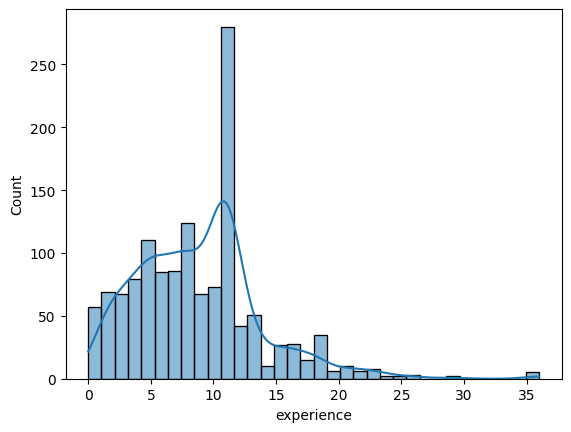

In [13]:
sns.histplot(df.query('experience<100')['experience'], kde=True)
plt.show()

Как видно, большинство пользователей с опытом 10 лет. Резкий пик у 12. И еще более резкий спад. Людей с опытом более 30 лет практически нет.

# posts_cnt - кол-во постов.

Посмотрим на распредление по кол-ву постов.

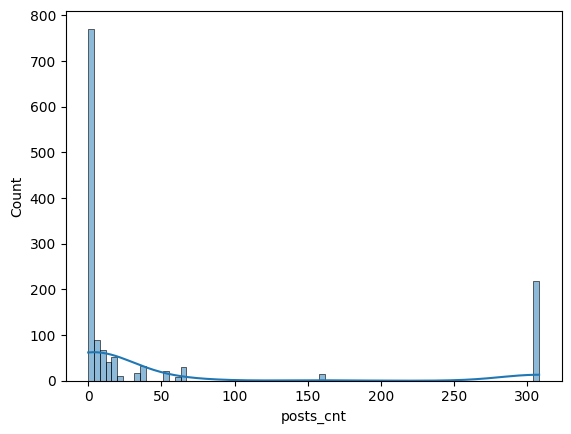

In [14]:

sns.histplot(df.posts_cnt, kde=True)
plt.show()

Большинство профилей не имеют постов. Есть единичные пики у 150 и 300. Посмотрим, сколько у нас таких пользователей.

In [15]:
df[df.posts_cnt>100]['name'].nunique()

2

2 пользователя с таким кол-вом постов.

# reaction_cnt - кол-во реакций.

Посмотрим на распределение reaction_cnt.

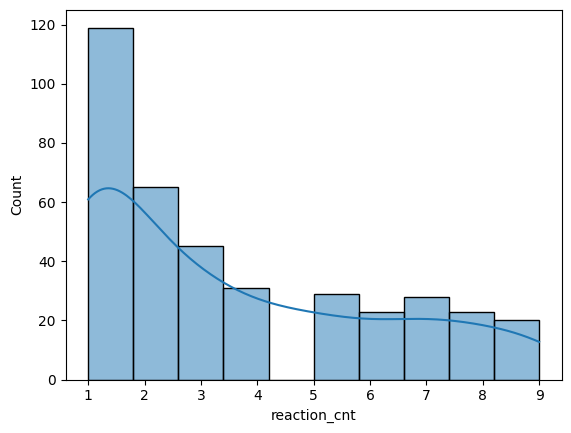

In [16]:
sns.histplot(df.reaction_cnt, kde=True)
plt.show()

Здесь график больше похож на равномерное распределение. Есть и провалы, конечно. Посмотрим сколько постов без реакций.

In [17]:
df.reaction_cnt.value_counts(dropna=False)

NaN    989
1.0    119
2.0     65
3.0     45
4.0     31
5.0     29
7.0     28
8.0     23
6.0     23
9.0     20
Name: reaction_cnt, dtype: int64

Получается, что около половины постов без реакций.

# comments_cnt - кол-во комментариев.

Посмотрим на распределение reaction_cnt.

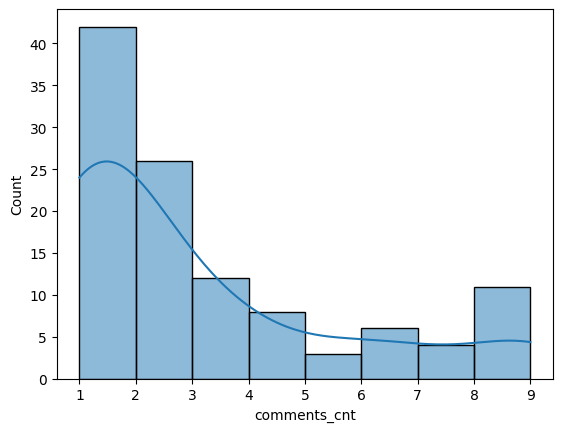

In [18]:
sns.histplot(df.comments_cnt, kde=True)
plt.show()

Здесь у нас пик у 1, далее спад. У большиства, конечно 0 в комментариях. Посмотрим, сколько их.

In [19]:
df.comments_cnt.value_counts(dropna=False)

NaN    1260
1.0      42
2.0      26
3.0      12
9.0       9
4.0       8
6.0       6
7.0       4
5.0       3
8.0       2
Name: comments_cnt, dtype: int64

3/4 постов без комментариев.

# repost_cnt - кол-во репостов.

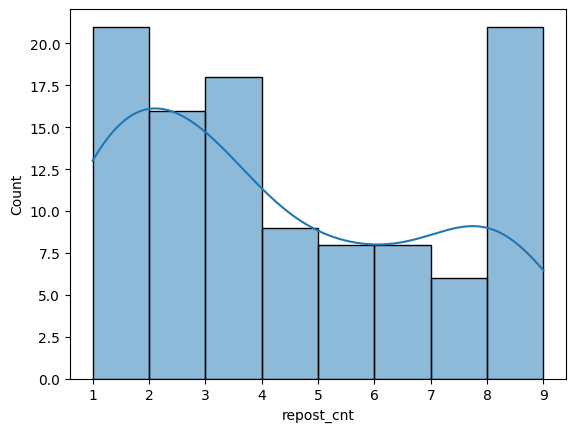

In [20]:

sns.histplot(df.repost_cnt, kde=True)
plt.show()

Здесь у нас пик у 1, далее спад. У большиства, конечно 0 в комментариях. Посмотрим, сколько их.

In [21]:
df.repost_cnt.value_counts(dropna=False)

NaN    1265
1.0      21
3.0      18
2.0      16
8.0      14
4.0       9
5.0       8
6.0       8
9.0       7
7.0       6
Name: repost_cnt, dtype: int64

3/4 постов без репостов.

Распределение репостов и комментариев очень похожи. Инетересно посмотреть, как они зависят друг от друга.

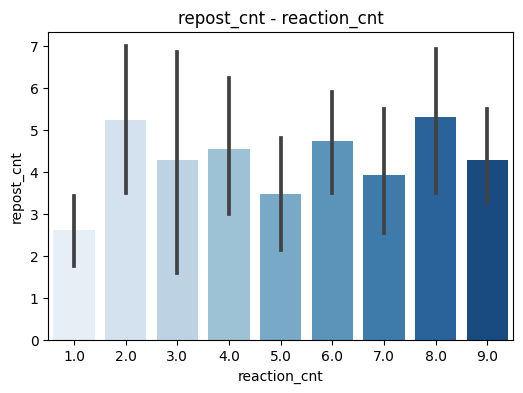

In [22]:
plt.figure(figsize=(6,4))
sns.barplot(x='reaction_cnt', y='repost_cnt', data = df, palette='Blues')
plt.title('repost_cnt - reaction_cnt')
plt.show()

Все также логично, с увеличением кол-ва реакций на пост, увеличивается кол-во тех,к то репостит.

Посмотрим связано ли кол-во репостов с реакциями.

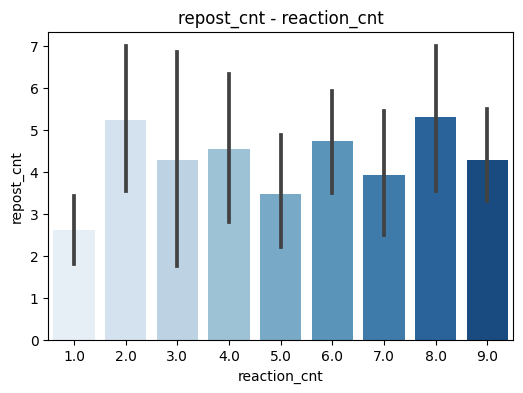

In [23]:
plt.figure(figsize=(6,4))
sns.barplot(x='reaction_cnt', y='repost_cnt', data = df, palette='Blues')
plt.title('repost_cnt - reaction_cnt')
plt.show()

In [24]:
df.head()

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt
0,https://www.linkedin.com/in/varvara-kulmeteva-...,senior web developer,Varvara Kulmeteva,Senior Web Developer - IBS InfinitySoft,IBS,Навыки: ReactJS · JavaScript · HTML · CSSНавык...,10.0,"Москва, Московская область, Россия",0,NaN,NaN,NaN,NaN
2,https://www.linkedin.com/in/denis-kuchkildin,middle data analyst,Denis Kuchkildin,Data Analyst at X5 Group,X5 Group,I have a strong engineering background and mor...,6.0,"Москва, Москва, Россия",1,Hi everyone - I am looking for a new role and ...,NaN,NaN,NaN
3,https://www.linkedin.com/in/ACoAAC4yJzEB4TjXkJ...,senior ML engineer,Ian Silantev,MSc Data Science in University of East London ...,Neurospot,"Absolutely in love with Data Science, AI and M...",2.0,"Тбилиси, Грузия",0,NaN,NaN,NaN,NaN
4,https://www.linkedin.com/in/oleg-malyshkin,senior test engineer,Oleg Malyshkin,Senior Test Automation Engineer at GlobalLogic,NaN,"Hi everyone, I am Oleg Malyshkin - Senior Test...",4.0,"Киев, Киев, Украина",9,Finding a job for trainees and juniors is a ch...,1.0,NaN,NaN
5,https://www.linkedin.com/in/oleg-malyshkin,senior test engineer,Oleg Malyshkin,Senior Test Automation Engineer at GlobalLogic,NaN,"Hi everyone, I am Oleg Malyshkin - Senior Test...",4.0,"Киев, Киев, Украина",9,Hi everyone!I am looking for a job as Junior U...,1.0,4.0,3.0


Проверим, есть ли в данных рекрутеры.

In [25]:
df[df['title'].str.contains('Recruit')==True]

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt
27,https://www.linkedin.com/in/ACoAAAqhWrQB8mmVQS...,lead frontend,Kristina Korobko,Lead IT Recruiter,DreamTeam,•\tkk@dream-team.tech•\tTelegram: @kkorobko•\t...,8.0,Россия,0,NaN,NaN,NaN,NaN
40,https://www.linkedin.com/in/ACoAABkz7KkBFOaZUx...,middle test engineer,Anastasia Usoltseva,Senior Technical Recruiter (Armenia/Serbia),Grid Dynamics,With nearly 5 years of experience in IT recrui...,9.0,"Белград, Сербия",0,NaN,NaN,NaN,NaN
639,https://www.linkedin.com/in/ACoAABkz7KkBFOaZUx...,lead frontend,Anastasia Usoltseva,Senior Technical Recruiter (Armenia/Serbia),Grid Dynamics,With nearly 5 years of experience in IT recrui...,9.0,"Белград, Сербия",0,NaN,NaN,NaN,NaN
668,https://www.linkedin.com/in/ACoAAAfSmP0BPGYrNv...,lead frontend,Lydia Saranina,Technical Talent Huntress at Anchous Drive Rec...,ADDFORCE Inc,9+ years of experience as a Full Cycle Technic...,13.0,Область залива Сан-Франциско,0,NaN,NaN,NaN,NaN
722,https://www.linkedin.com/in/ACoAAAqhWrQB8mmVQS...,lead frontend,Kristina Korobko,Lead IT Recruiter,DreamTeam,•\tkk@dream-team.tech•\tTelegram: @kkorobko•\t...,8.0,Россия,0,NaN,NaN,NaN,NaN
723,https://www.linkedin.com/in/ACoAABkz7KkBFOaZUx...,middle test engineer,Anastasia Usoltseva,Senior Technical Recruiter (Armenia/Serbia),Grid Dynamics,With nearly 5 years of experience in IT recrui...,9.0,"Белград, Сербия",0,NaN,NaN,NaN,NaN
740,https://www.linkedin.com/in/ACoAAEAtkocBP-DgeP...,frontend,Aisa Umakova,Sourcer / Junior IT Recruiter,Spice IT Recruitment Agency,"For the past nine months, I have been actively...",17.0,"Токио, Tokyo, Япония",0,NaN,NaN,NaN,NaN
818,https://www.linkedin.com/in/ACoAACYxveYBfh1wa2...,lead data analyst,Angelica Krytsina,IT-Recruitment Consultant – GlobalCareer,"GlobalCareer, Executive Search",Буду рада обсудить вакансии (локация - Москва/...,9.0,"Москва, Московская область, Россия",0,NaN,NaN,NaN,NaN
823,https://www.linkedin.com/in/ACoAAA5tS24BDNRFJX...,lead data analyst,Oksana Sovetnikova,Lead IT Recruiter – Jaxel,Jaxel,15000+ contactsWelcome =)15000+ contacts\nWelc...,18.0,"Санкт-Петербург, Санкт-Петербург, Россия",0,NaN,NaN,NaN,NaN
846,https://www.linkedin.com/in/ACoAAC1rrUUBa5JUg0...,lead data analyst,Daria Aleshina,Team Lead IT-Recruiter Dom.RF,ДОМ.РФ / DOM.RF,👩‍💻 Работаю на должности Team Lead IT-Recruite...,4.0,"Москва, Москва, Россия",0,NaN,NaN,NaN,NaN


Есть такие. Посмотрим сколько таких аккаунтов.

In [26]:
len(df[df['title'].str.contains('Recruiter')==True])

34

Почистим данные от рекрутеров.

In [27]:
df = df[df['title'].str.contains('Recruiter')==False]

In [28]:
df.shape

(1338, 13)

In [29]:
df.account_link.nunique()

695

Посмотрим на должности наших специалистов.

In [30]:
df.title.unique()

array(['Senior Web Developer - IBS InfinitySoft',
       'Data Analyst at X5 Group',
       'MSc Data Science in University of East London | Data Scientist | Machine Learning Engineer | Deep Learning Engineer',
       'Senior Test Automation Engineer at GlobalLogic',
       'Senior QA Engineer - Deutsche Bank', 'Data Engineer',
       'Javascript Software Engineer at EPAM Systems',
       'Senior Frontend Developer', 'Senior Web Developer – Devart',
       'Team Lead at Yandex', 'QA Engineer', 'Frontend developer',
       'QA Engineer - Kupibilet.ru',
       'ML Engineer | HSE University BSc Student',
       'ML Engineer @ SberDevices',
       'Team Lead | Data Analyst | Data Engineer | ML Engineer',
       'Lead QA Engineer',
       'Head of Mobile / Engineering Manager / Mobile Community Lead',
       'Blockchain and Backend developer at RedSteep',
       'Frontend Developer', 'IT-recruiter',
       'Frontend Developer | JavaScript | React | Redux  | TypeScript',
       'Frontend Dev

In [31]:
mistakes=['Ищу срочно: Главного геолога (изыскания)! Локация -Москва либо Тольятти', '17000+ | Комплексная помощь в поиске работы | im-konsalting.ru  | mail@im-konsalting.ru | WhatsApp/Telegram: 79643223069',
            'Руководитель подразделений маркетинга и стратегического развития в крупных компаниях на B2C рынке | 11 000+','Строю крутые отделы продаж. Обучаю в формате «Реалити». Я - Владимир Якуба',
            'Специалист по найму персонала – V Kontakte LLC',]
df=df.query('title not in @mistakes')

Итого  наш предобработанный файл:

In [32]:
df.shape

(1330, 13)

Это 1330 строк.

In [33]:
df.account_link.nunique()

690

690 уникальных пользователей.

In [34]:
df

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt
0,https://www.linkedin.com/in/varvara-kulmeteva-...,senior web developer,Varvara Kulmeteva,Senior Web Developer - IBS InfinitySoft,IBS,Навыки: ReactJS · JavaScript · HTML · CSSНавык...,10.0,"Москва, Московская область, Россия",0,NaN,NaN,NaN,NaN
2,https://www.linkedin.com/in/denis-kuchkildin,middle data analyst,Denis Kuchkildin,Data Analyst at X5 Group,X5 Group,I have a strong engineering background and mor...,6.0,"Москва, Москва, Россия",1,Hi everyone - I am looking for a new role and ...,NaN,NaN,NaN
3,https://www.linkedin.com/in/ACoAAC4yJzEB4TjXkJ...,senior ML engineer,Ian Silantev,MSc Data Science in University of East London ...,Neurospot,"Absolutely in love with Data Science, AI and M...",2.0,"Тбилиси, Грузия",0,NaN,NaN,NaN,NaN
4,https://www.linkedin.com/in/oleg-malyshkin,senior test engineer,Oleg Malyshkin,Senior Test Automation Engineer at GlobalLogic,NaN,"Hi everyone, I am Oleg Malyshkin - Senior Test...",4.0,"Киев, Киев, Украина",9,Finding a job for trainees and juniors is a ch...,1.0,NaN,NaN
5,https://www.linkedin.com/in/oleg-malyshkin,senior test engineer,Oleg Malyshkin,Senior Test Automation Engineer at GlobalLogic,NaN,"Hi everyone, I am Oleg Malyshkin - Senior Test...",4.0,"Киев, Киев, Украина",9,Hi everyone!I am looking for a job as Junior U...,1.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075,https://www.linkedin.com/in/nikolay-kozlov-073...,senior backend,NIkolay Kozlov,Senior software engineer (Java/Kotlin),The Software Development Company,Senior software engineer with strong skills in...,7.0,"Москва, Москва, Россия",0,NaN,NaN,NaN,NaN
2077,https://www.linkedin.com/in/%D0%B0%D0%BD%D0%B4...,senior backend,Андрей Пушин,Senior Backend developer - Лига Цифровой Эконо...,Лига Цифровой Экономики,Разработка системы имитации сигналов летательн...,8.0,"Королёв, Московская область, Россия",0,NaN,NaN,NaN,NaN
2078,https://www.linkedin.com/in/%D1%8E%D1%80%D0%B8...,senior backend,Юрий Черногорцев,Senior backend developer - Delivery Club,Delivery Club,"Стек: PHP, GoLang, Javascript + jQuery, CSS, M...",12.0,"Бали, Индонезия",2,Hi everyone - I am looking for a new role and ...,3.0,1.0,1.0
2079,https://www.linkedin.com/in/%D1%8E%D1%80%D0%B8...,senior backend,Юрий Черногорцев,Senior backend developer - Delivery Club,Delivery Club,"Стек: PHP, GoLang, Javascript + jQuery, CSS, M...",12.0,"Бали, Индонезия",2,NaN,1.0,NaN,NaN


## Подготовка текстов

Проведем очистку текста, а также токенизацию и лемматизацию.

In [35]:
model = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

Складываем все посты в один список

In [36]:
df.post_text.isna().sum()

814

In [37]:
df["post_text"] = df["post_text"].dropna()

In [38]:
df["post_text"]  = df["post_text"] .astype('str')

Посмотрим на кол-во символов в постах.

In [39]:
df["symbols"] = [len(x) for x in df['post_text']]

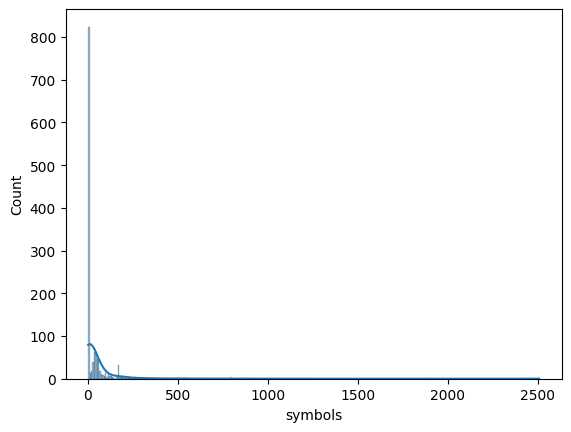

In [40]:
sns.histplot(df.symbols, kde=True)
plt.show()

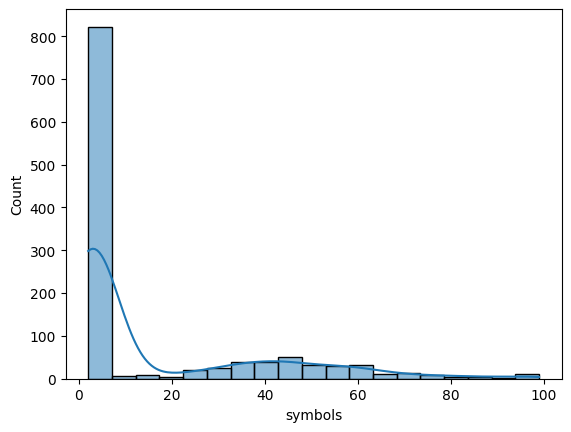

In [61]:
sns.histplot(df[df.symbols<=100].symbols, kde=True)
plt.show()

In [43]:
texts = df["post_text"].tolist()

Удалим знаки препинания, цифры и слова, содержащие цифры. Оставим только латиницу.


In [44]:
res = []
for doc in model.pipe(texts, disable=["tagger", "parser"]):
    res.append([token.lemma_ for token in doc])

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [45]:
with open("lemmas.json", "w") as fid:
    json.dump({"lemmas": res}, fid)

In [46]:
word_pattern = re.compile("^[a-zA-Z]*$")
def remove_symbols(doc):
    return [token for token in doc if word_pattern.match(token)]
texts = list(map(remove_symbols, res))
corpus = list(map(remove_symbols, res))

In [47]:
", ".join(corpus[np.random.randint(len(corpus))])

'nan'

## Векторизация текстов

Чтобы уменьшить размерность получаемой матрицы, добавим исключение стоп-слов.

In [48]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [49]:
tfidf = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.9)

Т.е. TfIdfVectorizer принимает на вход список предложений, поэтому необходимо объединить списки слов, составляющих корпус, в предложения.

In [50]:
docs = [" ".join(tokens) for tokens in corpus]
docs[:3]

['nan',
 'hi everyone i am looking for a new role and would appreciate your support thank you in advance for any connections advice or opportunities you can offer opentowork',
 'nan']

In [51]:
docs = list(filter(None, docs))

In [52]:
x = tfidf.fit_transform(docs)

In [53]:
x.shape

(1326, 90)

Теперь составим словарь {id_токена: токен} - он пригодится нам позднее.

In [54]:
id2word = {i: token for i, token in enumerate(tfidf.get_feature_names_out())}

## LDA

Теперь можем запустить алгоритм LDA. Зададим количество тем равное 5.

In [65]:
n_topics = 3

In [66]:
lda = LatentDirichletAllocation(n_components=n_topics, random_state=31)

In [67]:
topics = lda.fit_transform(x)

In [68]:
topics.shape

(1326, 3)

### Ключевые слова

In [69]:
for i in range(n_topics):
    c = lda.components_[i, :]
    topic_tokens = [id2word.get(token_id) for token_id in np.argsort(c)[-20:]]
    print("Тема",i+1, ":")
    print(", ".join(topic_tokens))
    print("\n ")

Тема 1 :
advice, offer, engineer, appreciate, advance, thank, support, opentowork, hi, would, google, opportunities, machine, looking, everyone, learning, new, guru, coursera, cloud

 
Тема 2 :
good, functions, frontend, science, like, work, programming, developer, experience, course, spreadsheets, completed, javascript, know, time, sql, introduction, data, python, datacamp

 
Тема 3 :
opentowork, good, fundamentals, learn, introduction, web, post, want, get, job, javascript, programming, aws, see, skill, earned, badge, next, linkedinskillassessment, nan

 


По полученным ключевым словам можно составить представление о содержании той или иной темы. Хотя иногда сочетания слов довольно странные )  

### Типичные статьи

Теперь для каждой темы возьмём по одному документу, который хорошо соответсвует этой теме. Для этого заглянем в массив _topics_.

In [70]:
for i in range(n_topics):
    doc_id = np.argmax(topics[:, i])
    print("Тема ", i)
    print(df.iloc[doc_id]["post_text"])
    print("\n")

Тема  0
Hi everyone - I am looking for a new role and would appreciate your support. Thank you in advance for any connections, advice, or opportunities you can offer. #OpenToWork


Тема  1
It seems that the peak of the hype about the current version of chatGPT is over. And before OpenAI rolls out the next release, which in addition to text, seems to be able to do pictures and video, I want to voice a thought about the expectations of large language models. Someone finds a lot of the most unexpected applications for them, and someone says "chatGPT is a useless dumbass, doesn't know basic things, can't solve logical problems". But if you take what chatGPT can do as the part of the human brain that is responsible for speech, then chatGPT is already doing just fine. You don't have to expect outstanding abilities in logic, factual knowledge, mathematics, spatial orientation, etc.  As I see it, in solving the problem of creating general artificial intelligence, some chatGPT analogue will act

Типичные статьи, в целом хорошо согласуются с ключевыми словами, которые мы выделили. Например, первая выделенная тема - про египтологию и археологию.
 В тоже время, мы видим и очень короткие тексты, например 4 и 14. Это подсказывает дальнейшие шаги. Например:
  - удалить из корпуса текстов очень короткие статьи. Чтобы правильно задать порог отсечения, необходимо построить распределение текстов по длине.   - возможно, ключевыми словами, на которые ориентировался алгоритм, стали названия информационных агентств - РБК и ИТАР-ТАСС. Стоит подумать о том, чтобы добавить эти слова в стоп-лист.

А ещё вы всегда можете сделать шаг назад и дополнить модель. Например:
- пополнить список стоп-слов (просмотрите внимательно ключевые слова каждой из тем - нет ли там случайных слов?);
- изменить настройки Tf-idF;
- увеличить/уменьшить количество тем;
- обучать LDA чуть дольше;
- заменить LDA на другой алгоритм тематического моделирояни.

# Полезные ссылки

- [Вики](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5)

- [История о том, как прочитать 120 тысяч анекдотов и не рассмеяться раньше времени](https://habr.com/ru/companies/otus/articles/723306/)

- [Видеоурок "Анализ текстовых данных тематическое моделирование комментариев Вконтакте"](https://www.youtube.com/watch?v=0DnfzQdbwQw)

- [LDA в Sklearn](https://scikit-learn.org/0.16/modules/generated/sklearn.lda.LDA.html)

- [Topic Modeling разными алгоритмами](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py)

- [Более академическое описание тематического моделировния](http://www.machinelearning.ru/wiki/index.php?title=%D0%A2%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5)